# 1. Import the libraries 

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import gzip
import pandas as pd
from urllib.request import urlopen
import joblib

# Load meta data and select relevant columns

In [2]:
### load the meta data
 
data = []
with gzip.open('C:\\Users\\POOJAANAND\\Documents\\Pulse\\Recommendation\\All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))
 
# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [3]:

electronics_df= pd.DataFrame.from_dict(data)

In [4]:
#naming the columns
electronics_df.rename(columns = {'overall':'Rating', 'asin':'ProductId',
                              'reviewTime':'Timestamp', 'reviewerID': 'UserId'}, inplace = True)

# 2. Load the dataset and add headers

In [5]:
electronics_df =electronics_df [['Rating','ProductId','UserId', 'Timestamp' ]]

In [6]:
electronics_df.head()

,Rating,ProductId,UserId,Timestamp
0,1.0,0143026860,A1V6B6TNIC10QE,"02 19, 2015"
1,4.0,0143026860,A2F5GHSXFQ0W6J,"12 18, 2014"
2,4.0,0143026860,A1572GUYS7DGSR,"08 10, 2014"
3,5.0,0143026860,A1PSGLFK1NSVO,"03 11, 2013"
4,5.0,0143026860,A6IKXKZMTKGSC,"12 25, 2011"


#### Dropping the timestamp column

In [7]:
electronics_df.drop('Timestamp',axis=1,inplace=True)

In [8]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Rating     371345 non-null  float64
 1   ProductId  371345 non-null  object 
 2   UserId     371345 non-null  object 
dtypes: float64(1), object(2)
memory usage: 8.5+ MB


In [9]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  371345
Number of columns:  3


In [10]:
#Check the datatypes
electronics_df.dtypes

Rating       float64
ProductId     object
UserId        object
dtype: object

In [11]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [12]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rating     50000 non-null  float64
 1   ProductId  50000 non-null  object 
 2   UserId     50000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [13]:
#Summary statistics of rating variable
electronics_df1['Rating'].describe().transpose()

count    50000.000000
mean         4.283360
std          1.216494
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

In [14]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.Rating.min()))
print('Maximum rating is: %d' %(electronics_df1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [15]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 Rating       0
ProductId    0
UserId       0
dtype: int64


* There are no missing records in the dataset.

## Ratings

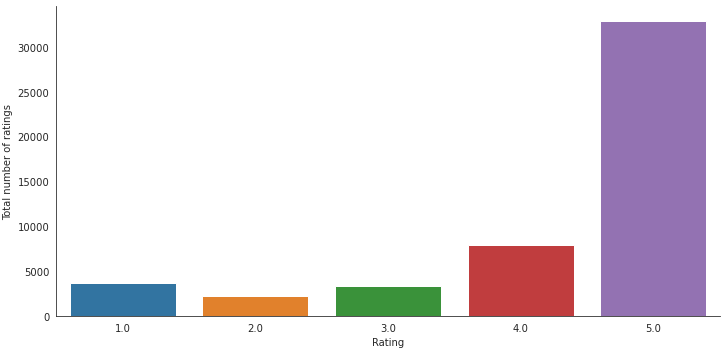

In [16]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

* We can see that more number of users have given the rating of 5.

# #Removing Duplicates

In [17]:
duplicate= electronics_df.drop_duplicates(['ProductId','UserId']).reset_index()

print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,index,Rating,ProductId,UserId
0,0,1.0,0143026860,A1V6B6TNIC10QE
1,1,4.0,0143026860,A2F5GHSXFQ0W6J
2,2,4.0,0143026860,A1572GUYS7DGSR
3,3,5.0,0143026860,A1PSGLFK1NSVO
4,4,5.0,0143026860,A6IKXKZMTKGSC
...,...,...,...,...
361600,371340,1.0,B01HJEGTYK,A202DCI7TV1022
361601,371341,5.0,B01HJEGTYK,A3FSOR5IJOFIBE
361602,371342,5.0,B01HJEGTYK,A1B5DK6CTP2P24
361603,371343,2.0,B01HJEGTYK,A23OUYS5IRMJS9


In [18]:
electronics_df.drop_duplicates()

,Rating,ProductId,UserId
0,1.0,0143026860,A1V6B6TNIC10QE
1,4.0,0143026860,A2F5GHSXFQ0W6J
2,4.0,0143026860,A1572GUYS7DGSR
3,5.0,0143026860,A1PSGLFK1NSVO
4,5.0,0143026860,A6IKXKZMTKGSC
...,...,...,...
371340,1.0,B01HJEGTYK,A202DCI7TV1022
371341,5.0,B01HJEGTYK,A3FSOR5IJOFIBE
371342,5.0,B01HJEGTYK,A1B5DK6CTP2P24
371343,2.0,B01HJEGTYK,A23OUYS5IRMJS9


## Users and products

In [19]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['ProductId'].nunique())

Number of unique users in Raw data =  47577
Number of unique product in Raw data =  370


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [20]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
ABLOQZIL42W7I     7
AIIR8E34EDKCQ     6
A2V1J3JT5OOZFO    6
A3RUBIOZYJNY0D    6
A3E5V5TSTAY3R9    6
A281NPSIMI1C2R    5
AAV5IVZ1RNQU1     5
A6FIAB28IS79      5
A141OPVE376YFI    4
A2JOBUCXKEXYY8    4
dtype: int64


In [21]:
counts=electronics_df1.UserId.value_counts()
counts


ABLOQZIL42W7I     7
AIIR8E34EDKCQ     6
A3RUBIOZYJNY0D    6
A3E5V5TSTAY3R9    6
A2V1J3JT5OOZFO    6
                 ..
A2IS9ZR3EQPLRN    1
A333JT0CG35YY7    1
A41KJ5G5Y7LJE     1
A2DQYT1OCYY1I     1
A35DDHCTBWCFX     1
Name: UserId, Length: 47577, dtype: int64

In [22]:
electronics_df1_final=electronics_df1[electronics_df1.UserId.isin(counts[counts>=5].index)]
print('Number of users who have rated 5 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['UserId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['ProductId'].nunique())

Number of users who have rated 5 or more items = 46
Number of unique users in the final data =  8
Number of unique products in the final data =  26


* electronics_df1_final has the users who have rated 5 or more items.

## ratings analysis in final dataset

In [23]:
final_ratings_matrix = electronics_df1_final.pivot_table(index='UserId', 
                        columns='ProductId', 
                        values='Rating').fillna(0)
final_ratings_matrix.columns.name = None
final_ratings_matrix.head()



,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
UserId,,,,,,,,,,,,,,,,,,,,,
A281NPSIMI1C2R,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2V1J3JT5OOZFO,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0
A3E5V5TSTAY3R9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3RUBIOZYJNY0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A6FIAB28IS79,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [24]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (8, 26)


* We can see that there are 26 products and 8 users.

In [25]:
np.count_nonzero(final_ratings_matrix)

32

26

In [26]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  32
possible_num_of_ratings =  208
density: 15.38%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [27]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,Rating,ProductId,UserId
49689,5.0,B000URXP6E,A3RUBIOZYJNY0D
20117,5.0,B0006O10P4,A3E5V5TSTAY3R9
18640,5.0,B0002JHI1I,A281NPSIMI1C2R
22621,5.0,B0009RF9DW,AIIR8E34EDKCQ
18641,5.0,B0002JHI1I,A281NPSIMI1C2R


In [28]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (32, 3)
Shape of testing data:  (14, 3)


# 5. Building Popularity Recommder model

In [29]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head(40)

,ProductId,score
0,B000050FDT,1
1,B000052YD8,1
2,B0000530HU,1
3,B000067E30,1
4,B00006IGL2,1
5,B00009RB0Y,1
6,B00009RB1I,1
7,B0000C4KJV,1
8,B0001WXTPA,1
9,B00021DJ32,2


In [30]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ProductId,score,rank
11,B0006O10P4,4,1.0
13,B0009RF9DW,3,2.0
9,B00021DJ32,2,3.0
10,B0002JHI1I,2,4.0
14,B000FI4S1E,2,5.0


In [31]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [32]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

    UserId   ProductId  score  rank
11      10  B0006O10P4      4   1.0
13      10  B0009RF9DW      3   2.0
9       10  B00021DJ32      2   3.0
10      10  B0002JHI1I      2   4.0
14      10  B000FI4S1E      2   5.0


The list of recommendations for the userId: 100

    UserId   ProductId  score  rank
11     100  B0006O10P4      4   1.0
13     100  B0009RF9DW      3   2.0
9      100  B00021DJ32      2   3.0
10     100  B0002JHI1I      2   4.0
14     100  B000FI4S1E      2   5.0


The list of recommendations for the userId: 150

    UserId   ProductId  score  rank
11     150  B0006O10P4      4   1.0
13     150  B0009RF9DW      3   2.0
9      150  B00021DJ32      2   3.0
10     150  B0002JHI1I      2   4.0
14     150  B000FI4S1E      2   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [33]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,Rating,ProductId,UserId
0,49689,5.0,B000URXP6E,A3RUBIOZYJNY0D
1,20117,5.0,B0006O10P4,A3E5V5TSTAY3R9
2,18640,5.0,B0002JHI1I,A281NPSIMI1C2R
3,22621,5.0,B0009RF9DW,AIIR8E34EDKCQ
4,18641,5.0,B0002JHI1I,A281NPSIMI1C2R


## User Based Collaborative Filtering model

In [34]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot_table(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.columns.name = None
pivot_df.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
UserId,,,,,,,,,,,,,,,,,,,,,
A281NPSIMI1C2R,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2V1J3JT5OOZFO,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0
A3E5V5TSTAY3R9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3RUBIOZYJNY0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A6FIAB28IS79,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (8, 26)


In [36]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E,user_index
UserId,,,,,,,,,,,,,,,,,,,,,
A281NPSIMI1C2R,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A2V1J3JT5OOZFO,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,1
A3E5V5TSTAY3R9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A3RUBIOZYJNY0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3
A6FIAB28IS79,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4


In [37]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [38]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 7)

In [39]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-2.63124937e-01  2.52770479e-15  8.46257592e-03  5.14076885e-01
   1.48196802e-16 -7.75009224e-01  1.44437778e-01]
 [-1.40146245e-01  1.10872165e-15  9.72775984e-01 -3.61605064e-02
  -4.09694732e-16  3.48913725e-02  1.47893874e-01]
 [ 5.85663111e-01 -5.36427451e-15  4.94897889e-04  2.67717469e-01
   3.33202067e-16 -1.84200497e-01  1.82008250e-01]
 [-6.18425903e-01  5.58400785e-15 -2.31195648e-01 -9.61808834e-02
  -4.85164733e-18  1.38957925e-01  5.96641383e-01]
 [ 7.06664240e-17  7.20578644e-17 -5.89086917e-16  1.82185679e-16
  -1.00000000e+00 -1.50441613e-16 -5.25940662e-17]
 [-8.84489681e-15 -1.00000000e+00 -1.82437465e-16  4.59031306e-17
  -6.04426270e-17 -2.06779918e-16 -5.08202025e-17]
 [ 1.00972331e-01 -9.36421908e-16 -1.03467605e-02 -8.08319736e-01
  -2.39880936e-17 -5.73650773e-01  6.46480608e-02]
 [ 4.18899761e-01 -3.44323958e-15 -8.74879627e-03 -1.06382943e-02
  -2.58280205e-16  1.25813187e-01  7.50984565e-01]]


In [40]:
print('Sigma: \n',sigma)

Sigma: 
 [ 6.41340583  6.55743852  8.76881271  8.97387085  9.74679434 10.96677916
 11.74454487]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [41]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 6.41340583  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          6.55743852  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          8.76881271  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          8.97387085  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          9.74679434  0.
   0.        ]
 [ 0.          0.          0.          0.          0.         10.96677916
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
  11.74454487]]


In [42]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 2.20370973e-17 -6.89563163e-15 -4.13737898e-15  7.08477682e-02
  -2.05136665e-01  5.50927431e-17 -1.09260390e-01  6.29757939e-02
  -1.42160871e-01  6.91855680e-01 -2.05136665e-01  2.14928801e-01
   6.29757939e-02 -1.55553965e-01 -8.74083121e-02  5.50927431e-17
   4.40741945e-17 -1.55553965e-01 -4.13737898e-15  7.87197424e-02
   5.50927431e-17 -6.55562341e-02  1.95708855e-01 -6.55562341e-02
  -6.55562341e-02 -4.82135327e-01]
 [ 2.19774426e-17 -7.62492852e-01 -4.57495711e-01 -6.42613510e-16
   1.92735683e-15  5.49436065e-17  8.45392330e-16 -5.71212009e-16
   1.35614482e-15 -5.89762234e-15  1.92735683e-15 -1.83564646e-15
  -5.71212009e-16  1.63232050e-15  6.76313864e-16  5.49436065e-17
   4.39548852e-17  1.63232050e-15 -4.57495711e-01 -7.14015011e-16
   5.49436065e-17  5.07235398e-16 -1.59312105e-15  5.07235398e-16
   5.07235398e-16  4.25776607e-15]
 [-1.34359562e-16 -1.04026321e-16 -6.24157926e-17 -5.30977497e-03
   4.82538298e-03 -3.35898904e-16  5.54679417e-

In [43]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
0,6.175684e-17,-1.271102e-16,-7.626613e-17,5.277543e-02,4.775415e+00,1.543921e-16,1.041960e-01,4.691149e-02,4.822326e+00,8.629098e-02,...,1.235137e-16,-7.497736e-02,-7.626613e-17,5.863936e-02,1.543921e-16,6.251763e-02,-3.566894e-01,6.251763e-02,6.251763e-02,4.490314e-01
1,-3.857478e-16,-3.150204e-16,-1.890122e-16,-2.448510e-02,1.041960e-01,-9.643694e-16,4.951658e+00,-2.176453e-02,8.243151e-02,-4.003460e-02,...,-7.714956e-16,3.478566e-02,-1.890122e-16,-2.720566e-02,-9.643694e-16,2.970995e+00,3.165486e+00,2.970995e+00,2.970995e+00,-2.083276e-01
2,-4.503875e-16,1.125914e-15,6.755483e-16,-1.792684e-01,7.628747e-01,-1.125969e-15,-3.539348e-01,-1.593497e-01,6.035250e-01,3.706885e+00,...,-9.007749e-16,2.546843e-01,6.755483e-16,-1.991871e-01,-1.125969e-15,-2.123609e-01,1.211608e+00,-2.123609e-01,-2.123609e-01,-1.525277e+00
3,5.507280e-17,-6.769298e-16,-4.061579e-16,-1.055182e-01,4.490314e-01,1.376820e-16,-2.083276e-01,-9.379394e-02,3.552375e-01,-1.725285e-01,...,1.101456e-16,5.149908e+00,-4.061579e-16,-1.172424e-01,1.376820e-16,-1.249966e-01,7.131580e-01,-1.249966e-01,-1.249966e-01,4.102215e+00
4,2.000000e+00,-5.807619e-17,-3.484571e-17,-1.221518e-16,1.543921e-16,5.000000e+00,-9.643694e-16,-1.085794e-16,4.581271e-17,2.625908e-16,...,4.000000e+00,1.301048e-15,-3.484571e-17,-1.357242e-16,5.000000e+00,-5.786217e-16,3.520709e-16,-5.786217e-16,-5.786217e-16,1.376820e-16


In [121]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [122]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B000PKKAGO                  0.0      7.131580e-01
B0002JHI1I                  0.0      4.490314e-01
B00006IGL2                  0.0      4.490314e-01
B0001WXTPA                  0.0      3.552375e-01
B00009RB0Y                  0.0      1.376820e-16


In [123]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B0006O10P4                  0.0      9.087306e-16
B000GGFZLC                  0.0      6.172466e-16
B000067E30                  0.0      5.555220e-16
B0000C4KJV                  0.0      4.937973e-16
B0009MFZAE                  0.0      4.937973e-16


In [124]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B0006O10P4                  0.0          1.113556
B000URXP6E                  0.0          1.047693
B00009RB1I                  0.0          0.243113
B000FEF1V4                  0.0          0.194491
B000PKKAFK                  0.0          0.145868


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model 

In [48]:
# Actual ratings given by the users
final_ratings_matrix.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
UserId,,,,,,,,,,,,,,,,,,,,,
A281NPSIMI1C2R,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2V1J3JT5OOZFO,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0
A3E5V5TSTAY3R9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3RUBIOZYJNY0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A6FIAB28IS79,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

B000050FDT    0.2500
B000052YD8    0.6250
B0000530HU    0.3750
B000067E30    0.5625
B00006IGL2    0.6250
dtype: float64

In [50]:
# Predicted ratings 
preds_df.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
0,6.175684e-17,-1.271102e-16,-7.626613e-17,5.277543e-02,4.775415e+00,1.543921e-16,1.041960e-01,4.691149e-02,4.822326e+00,8.629098e-02,...,1.235137e-16,-7.497736e-02,-7.626613e-17,5.863936e-02,1.543921e-16,6.251763e-02,-3.566894e-01,6.251763e-02,6.251763e-02,4.490314e-01
1,-3.857478e-16,-3.150204e-16,-1.890122e-16,-2.448510e-02,1.041960e-01,-9.643694e-16,4.951658e+00,-2.176453e-02,8.243151e-02,-4.003460e-02,...,-7.714956e-16,3.478566e-02,-1.890122e-16,-2.720566e-02,-9.643694e-16,2.970995e+00,3.165486e+00,2.970995e+00,2.970995e+00,-2.083276e-01
2,-4.503875e-16,1.125914e-15,6.755483e-16,-1.792684e-01,7.628747e-01,-1.125969e-15,-3.539348e-01,-1.593497e-01,6.035250e-01,3.706885e+00,...,-9.007749e-16,2.546843e-01,6.755483e-16,-1.991871e-01,-1.125969e-15,-2.123609e-01,1.211608e+00,-2.123609e-01,-2.123609e-01,-1.525277e+00
3,5.507280e-17,-6.769298e-16,-4.061579e-16,-1.055182e-01,4.490314e-01,1.376820e-16,-2.083276e-01,-9.379394e-02,3.552375e-01,-1.725285e-01,...,1.101456e-16,5.149908e+00,-4.061579e-16,-1.172424e-01,1.376820e-16,-1.249966e-01,7.131580e-01,-1.249966e-01,-1.249966e-01,4.102215e+00
4,2.000000e+00,-5.807619e-17,-3.484571e-17,-1.221518e-16,1.543921e-16,5.000000e+00,-9.643694e-16,-1.085794e-16,4.581271e-17,2.625908e-16,...,4.000000e+00,1.301048e-15,-3.484571e-17,-1.357242e-16,5.000000e+00,-5.786217e-16,3.520709e-16,-5.786217e-16,-5.786217e-16,1.376820e-16


In [51]:
# Average PREDICTED rating for each item
preds_df.mean().head()

B000050FDT    0.250000
B000052YD8    0.625000
B0000530HU    0.375000
B000067E30    0.544108
B00006IGL2    0.703268
dtype: float64

In [52]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(26, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
B000050FDT,0.2500,0.250000,0
B000052YD8,0.6250,0.625000,1
B0000530HU,0.3750,0.375000,2
B000067E30,0.5625,0.544108,3
B00006IGL2,0.6250,0.703268,4


In [58]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.05911 




# 9.  Item Based Model (Content Based Model)

In [84]:
# Matrix with row per 'user' and column per 'item' 
pivot_df1 = electronics_df_CF.pivot_table(index = 'ProductId', columns ='UserId', values = 'Rating').fillna(0)
pivot_df1.columns.name = None
pivot_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
ProductId,,,,,,,,
B000050FDT,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
B000052YD8,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
B0000530HU,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
B000067E30,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
B00006IGL2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
print('Shape of the pivot table: ', pivot_df1.shape)

Shape of the pivot table:  (26, 8)


In [86]:
#define user index from 0 to 10
pivot_df1['prod_index'] = np.arange(0, pivot_df1.shape[0], 1)
pivot_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ,prod_index
ProductId,,,,,,,,,
B000050FDT,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
B000052YD8,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1
B0000530HU,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2
B000067E30,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,3
B00006IGL2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [87]:
pivot_df1.set_index(['prod_index'], inplace=True)
# Actual ratings given by users
pivot_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
prod_index,,,,,,,,
0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* As this is a sparse matrix we will use SVD.

Singular Value decomposition

In [88]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df1, k = 7)

In [89]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 5.27245543e-17  6.15729590e-17  3.69645536e-17 -2.76316318e-17
   2.05195670e-01  3.79267287e-17 -2.61093998e-18]
 [-2.01882395e-15  7.62492852e-01  1.61512332e-17 -2.49711499e-17
  -1.17163400e-16  6.92597222e-17  8.61597748e-17]
 [-1.21129437e-15  4.57495711e-01  9.69073989e-18 -1.49826900e-17
  -7.02980398e-17  4.15558333e-17  5.16958649e-17]
 [-7.08477682e-02 -1.58379148e-16  5.30977497e-03 -4.05336657e-01
   3.45916212e-17 -2.35386201e-01 -2.47703318e-02]
 [ 2.05136665e-01  6.86275757e-16 -4.82538298e-03  2.86429844e-01
   2.09065598e-16 -3.53344046e-01 -6.14914326e-02]
 [ 1.31811386e-16  1.53932398e-16  9.24113840e-17 -6.90790795e-17
   5.12989176e-01  9.48168218e-17 -6.52734994e-18]
 [ 1.09260390e-01  3.26040322e-16 -5.54679417e-01 -2.01476637e-02
  -6.24641668e-18  1.59077574e-02 -6.29627950e-02]
 [-6.29757939e-02 -1.40781465e-16  4.71979997e-03 -3.60299251e-01
   3.07481077e-17 -2.09232178e-01 -2.20180727e-02]
 [ 1.42160871e-01  5.45494291e-16 -1.055

In [90]:
print('Sigma: \n',sigma)

Sigma: 
 [ 6.41340583  6.55743852  8.76881271  8.97387085  9.74679434 10.96677916
 11.74454487]


In [91]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 6.41340583  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          6.55743852  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          8.76881271  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          8.97387085  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          9.74679434  0.
   0.        ]
 [ 0.          0.          0.          0.          0.         10.96677916
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
  11.74454487]]


In [92]:
print('Right singular matrix: \n',Vt) 

Right singular matrix: 
 [[ 2.63124937e-01  1.40146245e-01 -5.85663111e-01  6.18425903e-01
   1.69071982e-16 -2.58950745e-15 -1.00972331e-01 -4.18899761e-01]
 [ 9.00042217e-16  4.27597873e-16 -1.60698430e-15  1.48089838e-15
   2.01880447e-16  1.00000000e+00 -2.30791451e-16 -7.87895369e-16]
 [-8.46257592e-03 -9.72775984e-01 -4.94897889e-04  2.31195648e-01
   1.62067624e-16  2.83254277e-17  1.03467605e-02  8.74879627e-03]
 [ 5.14076885e-01 -3.61605064e-02  2.67717469e-01 -9.61808834e-02
  -1.23981348e-16 -4.48175749e-17 -8.08319736e-01 -1.06382943e-02]
 [ 4.07543877e-16 -1.21765078e-17 -2.31751290e-16 -1.98948926e-16
   1.00000000e+00 -2.28393512e-16  7.49238707e-17  2.16269281e-16]
 [-7.75009224e-01  3.48913725e-02 -1.84200497e-01  1.38957925e-01
   2.07967029e-16  1.51911215e-16 -5.73650773e-01  1.25813187e-01]
 [-1.44437778e-01 -1.47893874e-01 -1.82008250e-01 -5.96641383e-01
  -1.53321509e-17  2.02381468e-16 -6.46480608e-02 -7.50984565e-01]]


In [93]:
#Predicted ratings
all_prod_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df1 = pd.DataFrame(all_prod_predicted_ratings, columns = pivot_df1.columns)
preds_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
0,4.559233e-16,-2.642604e-16,-7.991195e-16,-1.390001e-17,2.000000e+00,-5.302613e-17,8.287294e-17,3.717222e-16
1,2.421736e-16,7.061935e-17,-8.361750e-16,-1.046503e-15,-1.325653e-16,5.000000e+00,-1.651520e-16,8.235018e-16
2,1.453042e-16,4.237161e-17,-5.017050e-16,-6.279020e-16,-7.953920e-17,3.000000e+00,-9.909119e-17,4.941011e-16
3,5.277543e-02,-2.448510e-02,-1.792684e-01,-1.055182e-01,1.864641e-16,-1.486368e-16,4.486220e+00,1.231372e-01
4,4.775415e+00,1.041960e-01,7.628747e-01,4.490314e-01,1.139808e-15,2.421736e-16,5.863936e-02,-5.240087e-01


In [94]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

B000050FDT    0.2500
B000052YD8    0.6250
B0000530HU    0.3750
B000067E30    0.5625
B00006IGL2    0.6250
dtype: float64

In [95]:
# Predicted ratings 
preds_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
0,4.559233e-16,-2.642604e-16,-7.991195e-16,-1.390001e-17,2.000000e+00,-5.302613e-17,8.287294e-17,3.717222e-16
1,2.421736e-16,7.061935e-17,-8.361750e-16,-1.046503e-15,-1.325653e-16,5.000000e+00,-1.651520e-16,8.235018e-16
2,1.453042e-16,4.237161e-17,-5.017050e-16,-6.279020e-16,-7.953920e-17,3.000000e+00,-9.909119e-17,4.941011e-16
3,5.277543e-02,-2.448510e-02,-1.792684e-01,-1.055182e-01,1.864641e-16,-1.486368e-16,4.486220e+00,1.231372e-01
4,4.775415e+00,1.041960e-01,7.628747e-01,4.490314e-01,1.139808e-15,2.421736e-16,5.863936e-02,-5.240087e-01


In [96]:
# Average PREDICTED rating for each item
preds_df1.mean().head()

A281NPSIMI1C2R    0.786901
A2V1J3JT5OOZFO    0.799494
A3E5V5TSTAY3R9    0.270745
A3RUBIOZYJNY0D    0.541593
A6FIAB28IS79      0.807692
dtype: float64

In [102]:
# Recommend the items with the highest predicted ratings

def recommend_users(prodID, pivot_df1, preds_df1, num_recommendations):
    # index starts at 0  
    prod_idx = prodID-1 
    # Get and sort the user's ratings
    sorted_prod_ratings = pivot_df1.iloc[prod_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_prod_predictions = preds_df1.iloc[prod_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_prod_ratings, sorted_prod_predictions], axis=1)
    temp.index.name = 'Recommended users'
    temp.columns = ['prod_ratings', 'prod_predictions']
    temp = temp.loc[temp.prod_ratings == 0]   
    temp = temp.sort_values('prod_predictions', ascending=False)
    print('\nBelow are the recommended users for prod(prod_id = {}):\n'.format(prodID))
    print(temp.head(num_recommendations))

In [103]:
prodID = 4
num_recommendations = 5
recommend_users(prodID, pivot_df1, preds_df1, num_recommendations) 


Below are the recommended users for prod(prod_id = 4):

                   prod_ratings  prod_predictions
Recommended users                                
AIIR8E34EDKCQ               0.0      1.231372e-01
A281NPSIMI1C2R              0.0      5.277543e-02
A6FIAB28IS79                0.0      1.864641e-16
AAV5IVZ1RNQU1               0.0     -1.486368e-16
A2V1J3JT5OOZFO              0.0     -2.448510e-02


In [105]:
prodID = 10
num_recommendations = 5
recommend_users(prodID, pivot_df1, preds_df1, num_recommendations) 


Below are the recommended users for prod(prod_id = 10):

                   prod_ratings  prod_predictions
Recommended users                                
A281NPSIMI1C2R              0.0      8.629098e-02
AAV5IVZ1RNQU1               0.0      1.545618e-16
A6FIAB28IS79                0.0     -6.689334e-16
ABLOQZIL42W7I               0.0     -2.253064e-02
A2V1J3JT5OOZFO              0.0     -4.003460e-02


# 10. Evaluation of Content item based recommendation model 

In [106]:
# Actual ratings given by the users
final_ratings_matrix.head()

,B000050FDT,B000052YD8,B0000530HU,B000067E30,B00006IGL2,B00009RB0Y,B00009RB1I,B0000C4KJV,B0001WXTPA,B00021DJ32,...,B000FEGUIW,B000FI4S1E,B000FTYALG,B000GGFZLC,B000H6A02A,B000PKKAFK,B000PKKAGO,B000PKMA2G,B000PKNPES,B000URXP6E
UserId,,,,,,,,,,,,,,,,,,,,,
A281NPSIMI1C2R,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2V1J3JT5OOZFO,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0
A3E5V5TSTAY3R9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3RUBIOZYJNY0D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A6FIAB28IS79,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [110]:
final_ratings_matrix1 = electronics_df1_final.pivot_table(index='ProductId', 
                        columns='UserId', 
                        values='Rating').fillna(0)
final_ratings_matrix1.columns.name = None
final_ratings_matrix1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
ProductId,,,,,,,,
B000050FDT,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
B000052YD8,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
B0000530HU,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
B000067E30,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
B00006IGL2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# Average ACTUAL rating for each user
final_ratings_matrix1.mean().head()

A281NPSIMI1C2R    0.769231
A2V1J3JT5OOZFO    0.807692
A3E5V5TSTAY3R9    0.330769
A3RUBIOZYJNY0D    0.576923
A6FIAB28IS79      0.807692
dtype: float64

In [113]:
# Predicted ratings 
preds_df1.head()

,A281NPSIMI1C2R,A2V1J3JT5OOZFO,A3E5V5TSTAY3R9,A3RUBIOZYJNY0D,A6FIAB28IS79,AAV5IVZ1RNQU1,ABLOQZIL42W7I,AIIR8E34EDKCQ
0,4.559233e-16,-2.642604e-16,-7.991195e-16,-1.390001e-17,2.000000e+00,-5.302613e-17,8.287294e-17,3.717222e-16
1,2.421736e-16,7.061935e-17,-8.361750e-16,-1.046503e-15,-1.325653e-16,5.000000e+00,-1.651520e-16,8.235018e-16
2,1.453042e-16,4.237161e-17,-5.017050e-16,-6.279020e-16,-7.953920e-17,3.000000e+00,-9.909119e-17,4.941011e-16
3,5.277543e-02,-2.448510e-02,-1.792684e-01,-1.055182e-01,1.864641e-16,-1.486368e-16,4.486220e+00,1.231372e-01
4,4.775415e+00,1.041960e-01,7.628747e-01,4.490314e-01,1.139808e-15,2.421736e-16,5.863936e-02,-5.240087e-01


In [114]:
# Average PREDICTED rating for each item
preds_df1.mean().head()

A281NPSIMI1C2R    0.786901
A2V1J3JT5OOZFO    0.799494
A3E5V5TSTAY3R9    0.270745
A3RUBIOZYJNY0D    0.541593
A6FIAB28IS79      0.807692
dtype: float64

In [115]:
rmse_df1 = pd.concat([final_ratings_matrix1.mean(), preds_df1.mean()], axis=1)
rmse_df1.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df1.shape)
rmse_df1['item_index'] = np.arange(0, rmse_df1.shape[0], 1)
rmse_df1.head()

(8, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
A281NPSIMI1C2R,0.769231,0.786901,0
A2V1J3JT5OOZFO,0.807692,0.799494,1
A3E5V5TSTAY3R9,0.330769,0.270745,2
A3RUBIOZYJNY0D,0.576923,0.541593,3
A6FIAB28IS79,0.807692,0.807692,4


In [116]:
RMSE1 = round((((rmse_df1.Avg_actual_ratings - rmse_df1.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE1))


RMSE SVD Model = 0.02948 



# 11. Getting top - K ( K = 5) recommendations of both User based & Item based models

In [125]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 5
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B000FI4S1E                  0.0      1.301048e-15
B0009RF9DW                  0.0      1.301048e-15
B000PKKAGO                  0.0      3.520709e-16
B00021DJ32                  0.0      2.625908e-16
B0002JHI1I                  0.0      1.543921e-16


In [119]:
# Enter 'prodID' and 'num_recommendations' for the user #
prodID = 5
num_recommendations = 5
recommend_users(prodID, pivot_df1, preds_df1, num_recommendations)


Below are the recommended users for prod(prod_id = 5):

                   prod_ratings  prod_predictions
Recommended users                                
A3E5V5TSTAY3R9              0.0      7.628747e-01
A3RUBIOZYJNY0D              0.0      4.490314e-01
A2V1J3JT5OOZFO              0.0      1.041960e-01
ABLOQZIL42W7I               0.0      5.863936e-02
A6FIAB28IS79                0.0      1.139808e-15


In [ ]:
Summarising insights

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering & Item based Content filtering  are personalised recommender systems, the recommendations are based on the past behavior of the user and item and is not dependent on any additional information.

* Item-based Content Filtering showed an RMSE of "0.02948" whereas Model-based Collaborative Filtering 0.05911.